# Full Processes Defined
### Rachel Wilson

## Table of Contents
<ul>
    <li><a href="#intro">0. Introduction</a></li>
    <li><a href="#importing">1. Importing Libriaries</a></li>
    <li><a href="#quality">2. Quality Analysis</a></li> 
    <li><a href="#preprocess">3. Preprocessing and Defining a Cleaning Function</a></li>
    <li><a href="#descriptive">4. Descriptive Analysis</a></li>
    <li><a href="#ml">5. Splitting, Training, and Testing</a></li>
    <li><a href="#testing">6. Conducting Tests</a></li>
    <li><a href="#analyze">7. Analyzing Metric Results</a></li>
    <li><a href="#datasets">8. Creating datasets with Results</a></li>
    <li><a href="#extracting">9. Extracting the Datasets</a></li>
    <li><a href="#conclusion">10. Conclusion</a></li>
</ul>

<a id='intro'></a>
## 0) Introduction

In this notebook, we are performing the processes that will define our python files. The purpose is to extract the dataset, clean it, re-encode any necessary values, perform analysis, train and test a model on the dataset, then save our deliverables to our data store.

- The cleaning function will be defined in this notebook and under cleaning.py

####  Research Question: 
Which factors influence game genre popularity? How can we accurately predict which demographics will play certain game genres?

####  Hypothesis: 
There is a direct correlation between demographic data and genres played, where certain demographics play certain genres. \
**Parameters:**
- Metrics score above 0.70 for GameGenre and priority 1 demographic data.
- Metrics are consistently above 0.70.

#### Null Hypothesis: 
There is no correlation between the genre and demographic data. \
**Parameters:**
- Metrics score below 0.70 for GameGenre and priority 1 demographic data.
- Metrics are not consistent.

<a id='importing'></a>
## 1) Importing Libraries and Files

In [1]:
# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import supplementary visualization code visuals.py
import visuals as vs

# Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import fbeta_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

# Import statsmodels for quick descriptive analysis
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

In [2]:
# Load game dataset

game_data = pd.read_csv("online_gaming_behavior_dataset.csv")

<a id='quality'></a>
## 2) Quality Analysis

Our first step is to examine the data quality and view the different columns. We are examining the quality of the data to determine what steps need to be done. Based on the examination, it looks like only preprocessing needs to be done.

### *Data Dictionary*


- PlayerID: Unique identifier for each player.
- Age: Age of the player.
- Gender: Gender of the player.
- Location: Geographic location of the player.
- GameGenre: Genre of the game the player is engaged in.
- PlayTimeHours: Average hours spent playing per session.
- InGamePurchases: Indicates whether the player makes in-game purchases (0 = No, 1 = Yes).
- GameDifficulty: Difficulty level of the game.
- SessionsPerWeek: Number of gaming sessions per week.
- AvgSessionDurationMinutes: Average duration of each gaming session in minutes.
- PlayerLevel: Current level of the player in the game.
- AchievementsUnlocked: Number of achievements unlocked by the player.
- EngagementLevel: Categorized engagement level reflecting player retention ('High', 'Medium', 'Low').

In [3]:
game_data.head(2)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium


In [4]:
game_data.tail(2)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium
40033,49033,19,Male,USA,Sports,10.083804,0,Easy,13,84,72,39,Medium


In [5]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [6]:
game_data.isnull().sum()

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

<a id='preprocess'></a>
## 3) Preprocessing and Defining a Cleaning Function

### Creating a Feature Dataset for Analysis

We begin our cleaning phase by creating a feature dataset to use for analysis. This is important as it allows us to compare key column demographics. The columns will be defined as our attributes, then we can categorize the data based on the type of value. From there, we assign a label based on the demographic level and priority level in the column.

Our main priority is to target the attributes that have a higher priority. We will attempt to build our model on those attributes first. 

Our highest priority demographical features are:
1. Age
2. Gender
3. Location

Then our last feature is the central target:

4. GameGenre

If unsuccessful in predicting these features and meeting our success criteria, we will move to lower priority demographic features.
We will do this until the model scores above 0.70, however the null hypothesis would be proven in this case.

In [7]:
# Creating a raw dataset to return after our process.

raw_data = game_data

In [8]:
# Dropping the ID column as it is not necessary for analysis

game_data = game_data.drop(['PlayerID'], axis=1)

In [9]:
attributes_vals = game_data.columns.tolist()

In [10]:
attributes = {'attributes':attributes_vals}

In [11]:
# Generates a lists of values and if they are categorical or numerical
x = 0
type_list = []

while x <= len(attributes_vals):
    try:
        cur_col = attributes_vals[x]
        if game_data[cur_col].nunique() > 2:
            if game_data[cur_col].dtypes == 'int64':
                type_list.append('numerical')
            elif game_data[cur_col].dtypes == 'float64':
                type_list.append('numerical')
            else:
                type_list.append('categorical')
            x += 1
        else:
            type_list.append('categorical')
            x += 1
    except IndexError as excpt:
        print('List done')
        break

List done


In [12]:
types = {'type': type_list}

In [13]:
demographic_level = {'demographic_level': ['personal', 'personal', 'personal', 'game', 'game', 'game', 'game', 'stat', 'stat', 'stat', 'stat', 'stat']}

In [14]:
priority = {'priority': [1, 1, 1, 1, 2, 3, 3, 2, 2, 3, 3, 2]}

In [15]:
a_df = pd.DataFrame(data=attributes, index = range(12))
t_df = pd.DataFrame(data=types, index = range(12))
i_df = pd.DataFrame(data=demographic_level, index = range(12))
p_df = pd.DataFrame(data=priority, index = range(12))

In [16]:
game_feature_summary = a_df.join((t_df, i_df, p_df), how='outer')

In [17]:
# Finished feature summary dataframe
game_feature_summary

,attributes,type,demographic_level,priority
0,Age,numerical,personal,1
1,Gender,categorical,personal,1
2,Location,categorical,personal,1
3,GameGenre,categorical,game,1
4,PlayTimeHours,numerical,game,2
5,InGamePurchases,categorical,game,3
6,GameDifficulty,categorical,game,3
7,SessionsPerWeek,numerical,stat,2
8,AvgSessionDurationMinutes,numerical,stat,2
9,PlayerLevel,numerical,stat,3


### Select and Re-Encode Features

Within this section, we evaluate our columns in order to re-encode the necessary values for analysis. All values must be converted to numerical, and all numerical values must fit into a reasonable scale.

In [18]:
# Create separate features based on the type

num_features = game_feature_summary[game_feature_summary['type'] == 'numerical']['attributes']
num_features

0                           Age
4                 PlayTimeHours
7               SessionsPerWeek
8     AvgSessionDurationMinutes
9                   PlayerLevel
10         AchievementsUnlocked
Name: attributes, dtype: object

In [19]:
# View the data to determine if it's skewed
num_cols = game_data[num_features]
num_cols.describe()

,Age,PlayTimeHours,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,31.992531,12.024365,9.471774,94.792252,49.655568,24.526477
std,10.043227,6.914638,5.763667,49.011375,28.588379,14.430726
min,15.000000,0.000115,0.000000,10.000000,1.000000,0.000000
25%,23.000000,6.067501,4.000000,52.000000,25.000000,12.000000
50%,32.000000,12.008002,9.000000,95.000000,49.000000,25.000000
75%,41.000000,17.963831,14.000000,137.000000,74.000000,37.000000
max,49.000000,23.999592,19.000000,179.000000,99.000000,49.000000


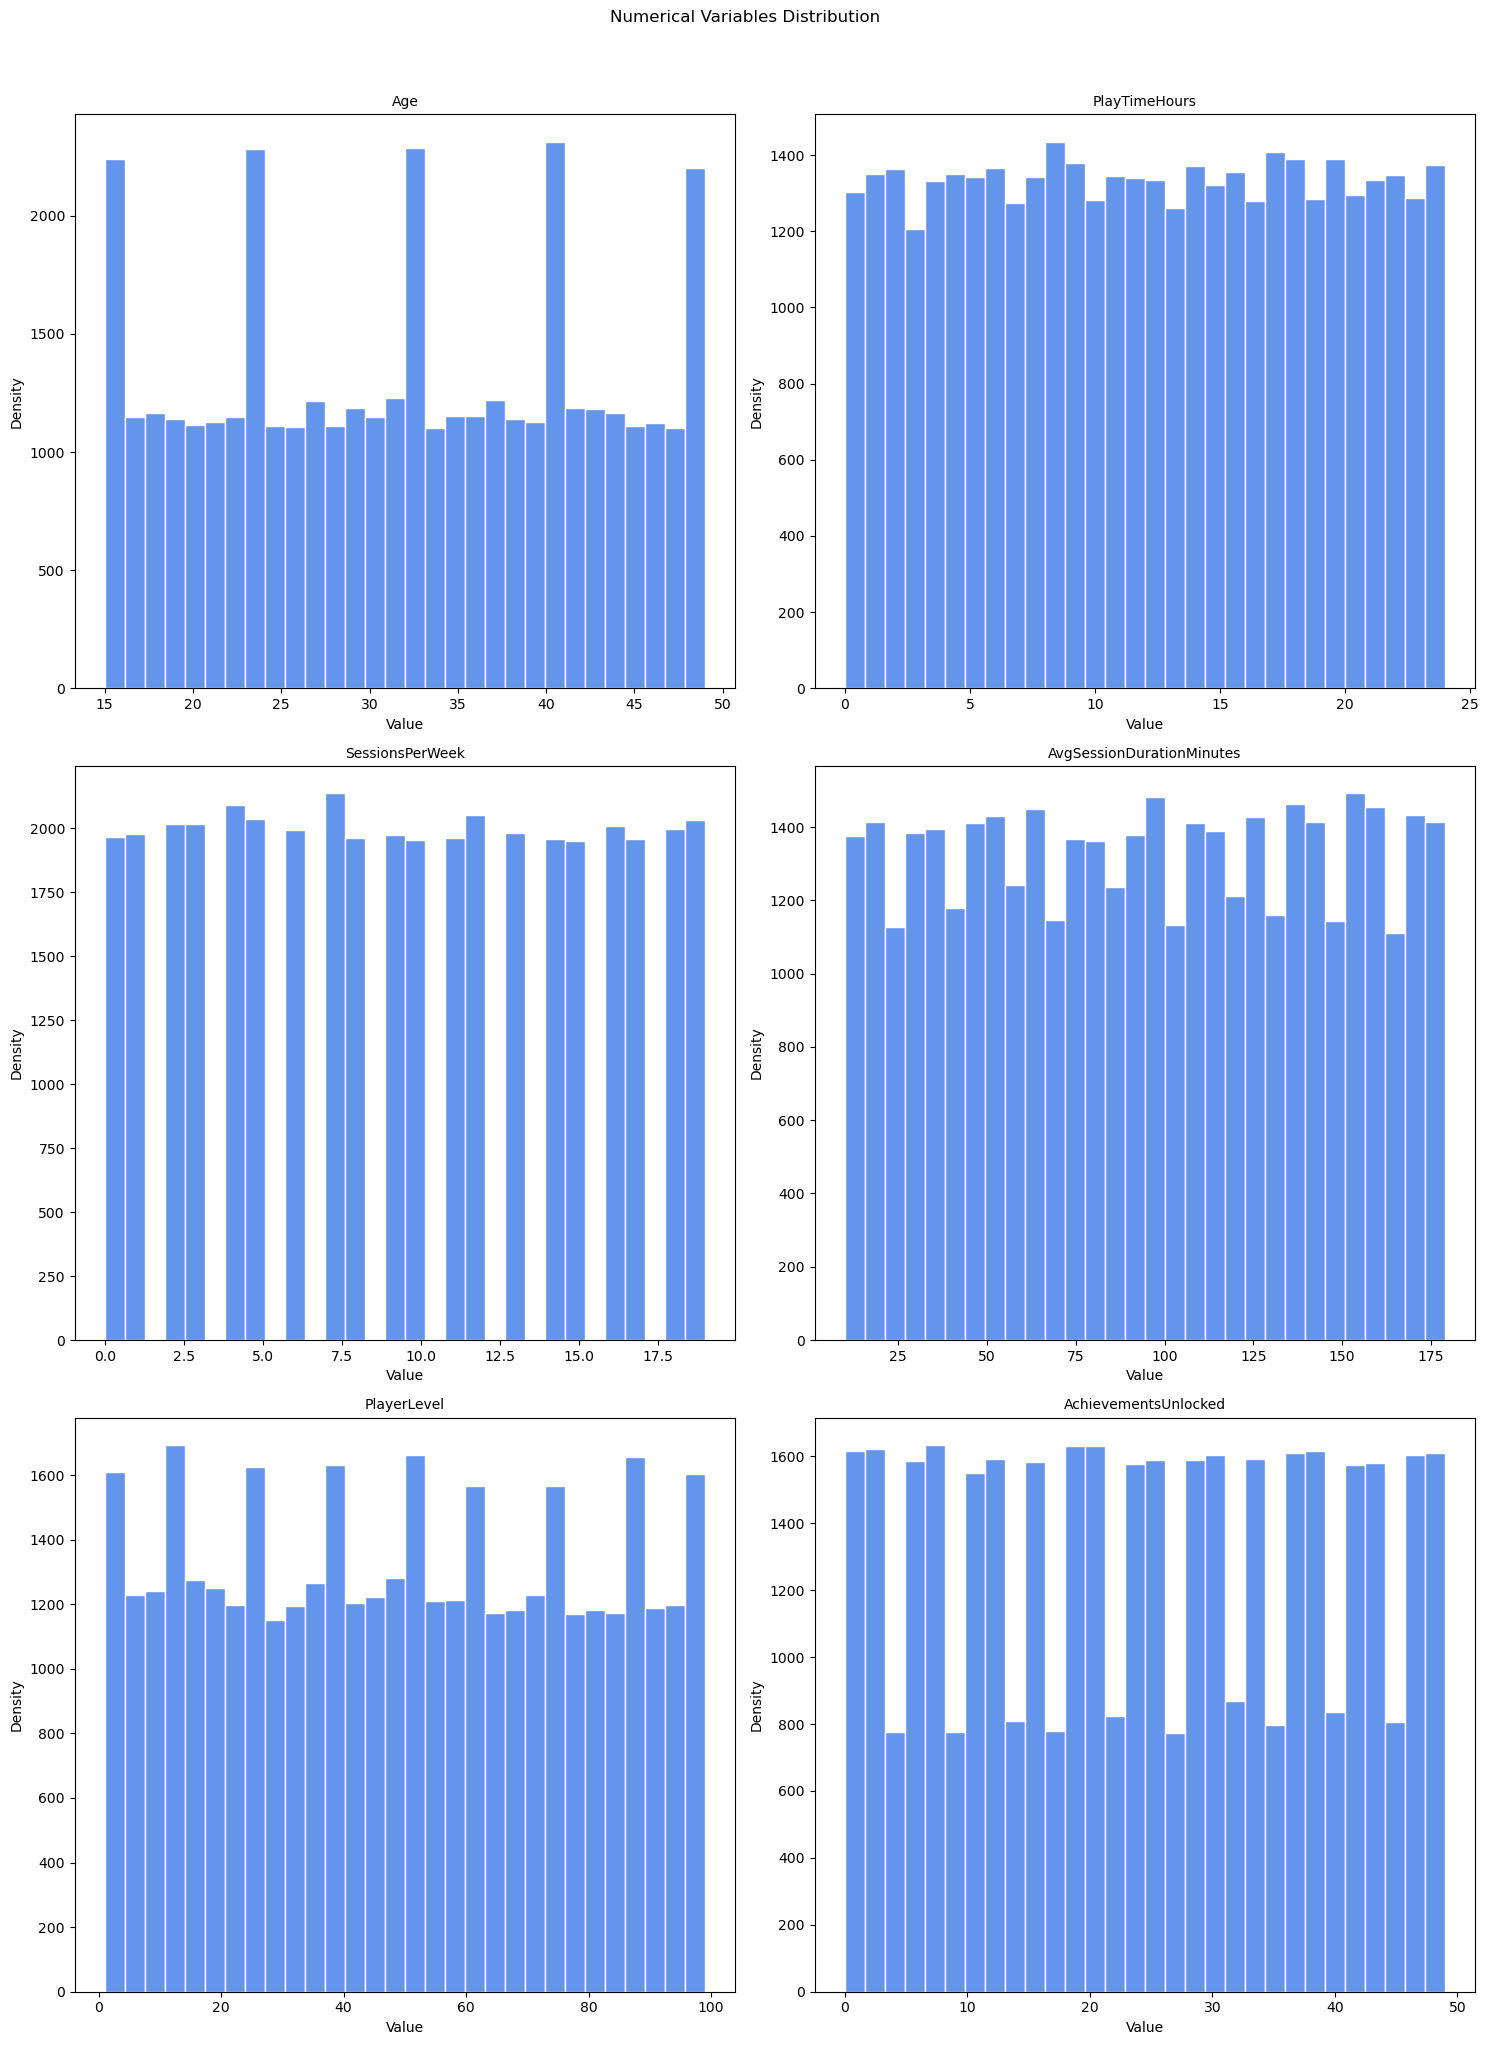

In [20]:
# Viewing the distribution of the numerical features

fig, axs = plt.subplots(len(num_features) // 2 + len(num_features) % 2, 2, figsize=(15, 20))
axs = axs.flatten()

for i, col in enumerate(num_features):
    vc = game_data[col].value_counts(normalize=True)
    axs[i].hist(game_data[col], bins=30, edgecolor='white', color='cornflowerblue')
    axs[i].set_title(col, fontsize=10)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')

plt.suptitle('Numerical Variables Distribution', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Dealing with the categorical features

cat_features = game_feature_summary[game_feature_summary['type'] == 'categorical']['attributes']

In [22]:
# Creating a copy for future reference
cat_features_copy = cat_features

In [23]:
# Dropping the engagement level to do specific encoding
cat_features = cat_features.drop(index=11)

# EngagementLevel has three different values, so we can substitute it with mapping.
e_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
game_data['EngagementLevel'] = game_data['EngagementLevel'].map(e_mapping)

for col in cat_features:
    vc = game_data[col].value_counts()
    mapping = {value: idx for idx, value in enumerate(vc.index)}
    game_data[col] = game_data[col].map(mapping)

In [24]:
cat_features = cat_features_copy

In [25]:
game_data

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,43,0,3,2,16.271119,0,1,6,108,79,25,1
1,29,1,0,2,5.525961,0,1,5,144,11,10,1
2,22,1,0,0,8.223755,0,0,16,142,35,41,2
3,35,0,0,1,5.265351,1,0,9,85,57,47,1
4,33,0,1,1,15.531945,0,1,2,131,95,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...
40029,32,0,0,2,20.619662,0,0,4,75,85,14,1
40030,44,1,3,3,13.539280,0,2,19,114,71,27,2
40031,15,1,0,4,0.240057,1,0,10,176,29,1,2
40032,34,0,0,0,14.017818,1,1,3,128,70,10,1


### Cleaning Function

In [26]:
def feature_list(df):
    '''
    Creates a feature list based on the game_data dataframe.
    
    Parameters:
    df (DataFrame): The game_data dataframe object.
    
    Returns:
    game_feature_summary (DataFrame): A dataframe object with the features summarized.
    
    '''
    attributes_vals = df.columns.tolist()
    attributes = {'attributes':attributes_vals}
    
    x = 0
    type_list = []

    while x <= len(attributes_vals):
        try:
            cur_col = attributes_vals[x]
            if df[cur_col].nunique() > 2:
                if df[cur_col].dtypes == 'int64':
                    type_list.append('numerical')
                elif df[cur_col].dtypes == 'float64':
                    type_list.append('numerical')
                else:
                    type_list.append('categorical')
                x += 1
            else:
                type_list.append('categorical')
                x += 1
        except IndexError as excpt:
            break
            
    types = {'type': type_list}
    
    demographic_level = {'demographic_level': ['personal', 'personal', 'personal', 'game', 'game', 'game', 'game', 'stat', 'stat', 'stat', 'stat', 'stat']}
    priority = {'priority': [1, 1, 1, 1, 2, 3, 3, 2, 2, 3, 3, 2]}
    
    a_df = pd.DataFrame(data=attributes, index = range(12))
    t_df = pd.DataFrame(data=types, index = range(12))
    i_df = pd.DataFrame(data=demographic_level, index = range(12))
    p_df = pd.DataFrame(data=priority, index = range(12))
    
    game_feature_summary = a_df.join((t_df,i_df, p_df), how='outer')
    
    return game_feature_summary

In [27]:
def cleaning_function(df):
    '''
    This is the final designed cleaning function for the dataset. 
    This function completes preprocessing steps before analysis.
    
    Parameters:
    df (DataFrame): Dataframe object to clean.
    
    Returns:
    df (DataFrame): Cleaned dataframe object.
    
    '''
    
    df = df.drop(['PlayerID'], axis=1)
    
    game_feature_summary = feature_list(df)
    
    num_features = game_feature_summary[game_feature_summary['type'] == 'numerical']['attributes']
    cat_features = game_feature_summary[game_feature_summary['type'] == 'categorical']['attributes']
    
    cat_features = cat_features.drop(index=11)

    # EngagementLevel has three different values, thus we can substitute it with mapping.
    e_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    df['EngagementLevel'] = df['EngagementLevel'].map(e_mapping)

    for col in cat_features:
        vc = df[col].value_counts()
        mapping = {value: idx for idx, value in enumerate(vc.index)}
        df[col] = df[col].map(mapping)
    
    return df, game_feature_summary


In [28]:
## Demonstracting the cleaning function in .py format

In [29]:
import cleaning as cl

In [30]:
# Load game dataset

df = pd.read_csv("online_gaming_behavior_dataset.csv")

In [31]:
df, feat = cl.cleaning_function(df)

In [32]:
df

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,43,0,3,2,16.271119,0,1,6,108,79,25,1
1,29,1,0,2,5.525961,0,1,5,144,11,10,1
2,22,1,0,0,8.223755,0,0,16,142,35,41,2
3,35,0,0,1,5.265351,1,0,9,85,57,47,1
4,33,0,1,1,15.531945,0,1,2,131,95,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...
40029,32,0,0,2,20.619662,0,0,4,75,85,14,1
40030,44,1,3,3,13.539280,0,2,19,114,71,27,2
40031,15,1,0,4,0.240057,1,0,10,176,29,1,2
40032,34,0,0,0,14.017818,1,1,3,128,70,10,1


<a id='descriptive'></a>
## 4) Descriptive Analysis

Within this section, we are conducting descriptive data analysis in order to understand each column's values. After our visual inspection in the File Analysis section, we are defining the main features and characteristics. We will evaluate how certain values interact with each other. This is supplemental to how we will evaluate correlated values.

### Graph Functions

In [33]:
def create_pie(df, label):
    '''
    Creates a pie chart based on the amount of values compared to the whole.
    
    Parameters:
    df (DataFrame): DataFrame object to plot.
    label (str): The column to divide into unique values, then compare.
    
    Returns:
    None
    
    '''
    
    _count = df[label].value_counts()
    lvls = _count.index.tolist()
    counts = _count.values.tolist()
    total_counts = sum(counts)

    percents = [(count / total_counts) * 100 for count in counts]

    plt.figure(figsize=(12, 6))
    plt.pie(percents, labels=lvls, autopct='%1.1f%%', 
            shadow=True)

    plt.title(f"Proportion of {label}")
    plt.axis('equal')

    plt.show()

In [34]:
def correlation_create(df, target):
    '''
    Creates a correlation graph based on a dataframe and it's target column.
    
    Parameters:
    df (DataFrame): Dataframe object to correlate against the target.
    target (string): The column's name to target
    
    Returns:
    None
    '''
    
    corr = df.corr()

    target_corr = corr[target].drop(target)

    sns.set(font_scale=1.2)
    sns.set_style("white")
    sns.set_palette("pastel")
    sns.heatmap(target_corr.to_frame(), cmap="YlGnBu", annot=True, fmt='.2f')
    plt.title('Correlation with {} Column'.format(target))
    plt.show()

### Logistic Regression

In [35]:
# Create a new game_data opject to perform analysis on.
# We will compare this to the preprocessed data

gdata_copy = raw_data.drop('PlayerID', axis=1, inplace=False)

In [36]:
gdata_copy['Location'].value_counts()

Location
USA       16000
Europe    12004
Asia       8095
Other      3935
Name: count, dtype: int64

In [37]:
gdata_copy.describe()

,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,31.992531,12.024365,0.200854,9.471774,94.792252,49.655568,24.526477
std,10.043227,6.914638,0.400644,5.763667,49.011375,28.588379,14.430726
min,15.000000,0.000115,0.000000,0.000000,10.000000,1.000000,0.000000
25%,23.000000,6.067501,0.000000,4.000000,52.000000,25.000000,12.000000
50%,32.000000,12.008002,0.000000,9.000000,95.000000,49.000000,25.000000
75%,41.000000,17.963831,0.000000,14.000000,137.000000,74.000000,37.000000
max,49.000000,23.999592,1.000000,19.000000,179.000000,99.000000,49.000000


In [38]:
game_data.describe()

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,31.992531,0.401534,0.999126,1.993805,12.024365,0.200854,0.700080,9.471774,94.792252,49.655568,24.526477,1.000300
std,10.043227,0.490215,0.997524,1.413811,6.914638,0.400644,0.781053,5.763667,49.011375,28.588379,14.430726,0.718383
min,15.000000,0.000000,0.000000,0.000000,0.000115,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,1.000000,6.067501,0.000000,0.000000,4.000000,52.000000,25.000000,12.000000,0.000000
50%,32.000000,0.000000,1.000000,2.000000,12.008002,0.000000,1.000000,9.000000,95.000000,49.000000,25.000000,1.000000
75%,41.000000,1.000000,2.000000,3.000000,17.963831,0.000000,1.000000,14.000000,137.000000,74.000000,37.000000,2.000000
max,49.000000,1.000000,3.000000,4.000000,23.999592,1.000000,2.000000,19.000000,179.000000,99.000000,49.000000,2.000000


In [39]:
gdata_copy['GameGenre'].value_counts()

GameGenre
Sports        8048
Action        8039
Strategy      8012
Simulation    7983
RPG           7952
Name: count, dtype: int64

In [40]:
gdata_copy[['Low', 'Medium', 'High']] = pd.get_dummies(gdata_copy['EngagementLevel'], dtype=int)
gdata_copy = gdata_copy.drop('EngagementLevel', axis=1)

gdata_copy[['Sports', 'Action', 'Strategy', 'Simulation', 'RPG']] = pd.get_dummies(gdata_copy['GameGenre'], dtype=int)

In [41]:
# Dropping GameGenre column
gdata_copy = gdata_copy.drop('GameGenre', axis=1)

#Dropping RPG as it can be our '0' column
gdata_copy = gdata_copy.drop('RPG', axis=1)

In [42]:
gdata_copy['intercept'] = 1
X = gdata_copy[['intercept', 'Sports', 'Action', 'Strategy', 'Simulation']]
y = gdata_copy['High']

In [43]:
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.692586
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                   High   No. Observations:                40034
Model:                          Logit   Df Residuals:                    40029
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Jul 2024   Pseudo R-squ.:               6.552e-05
Time:                        11:58:28   Log-Likelihood:                -27727.
converged:                       True   LL-Null:                       -27729.
Covariance Type:            nonrobust   LLR p-value:                    0.4579
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0484      0.022     -2.167      0.030      -0.092      -0.005
Sports        -0.0031      0.

In [44]:
# Let's perform the same actions again for the demographical features
gdata_copy = raw_data.drop('PlayerID', axis=1, inplace=False)

gdata_copy[['Low', 'Medium', 'High']] = pd.get_dummies(gdata_copy['EngagementLevel'], dtype=int)

gdata_copy = gdata_copy.drop('EngagementLevel', axis=1)

gdata_copy[['USA', 'Europe', 'Asia', 'Other']] = pd.get_dummies(gdata_copy['Location'], dtype=int)

# Dropping Location column
gdata_copy = gdata_copy.drop('Location', axis=1)

#Dropping 'Other' as it can be our '0' column
gdata_copy = gdata_copy.drop('Other', axis=1)

gdata_copy['intercept'] = 1
X = gdata_copy[['intercept', 'USA', 'Europe', 'Asia']]
y = gdata_copy['High']

logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.692621
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                   High   No. Observations:                40034
Model:                          Logit   Df Residuals:                    40030
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Jul 2024   Pseudo R-squ.:               1.539e-05
Time:                        11:58:28   Log-Likelihood:                -27728.
converged:                       True   LL-Null:                       -27729.
Covariance Type:            nonrobust   LLR p-value:                    0.8367
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0535      0.016     -3.383      0.001      -0.085      -0.023
USA           -0.0164      0.

### Plot Analysis

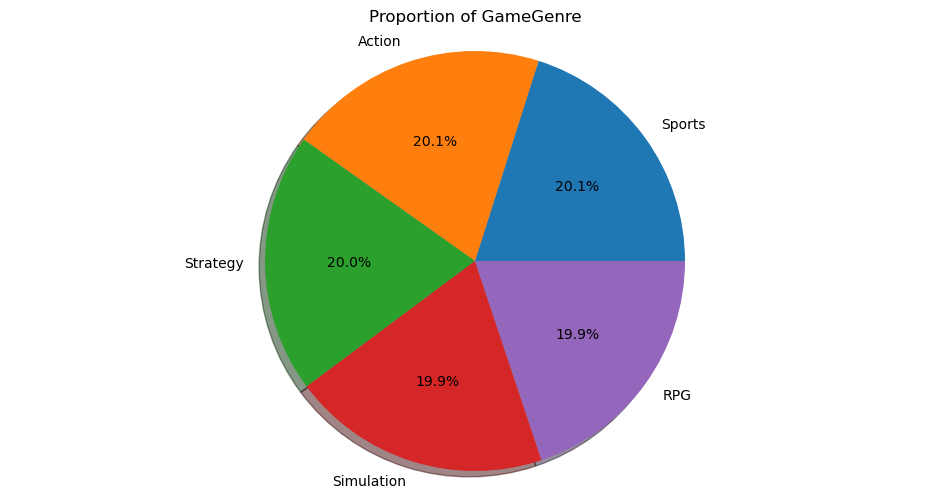

In [45]:
create_pie(raw_data, 'GameGenre')

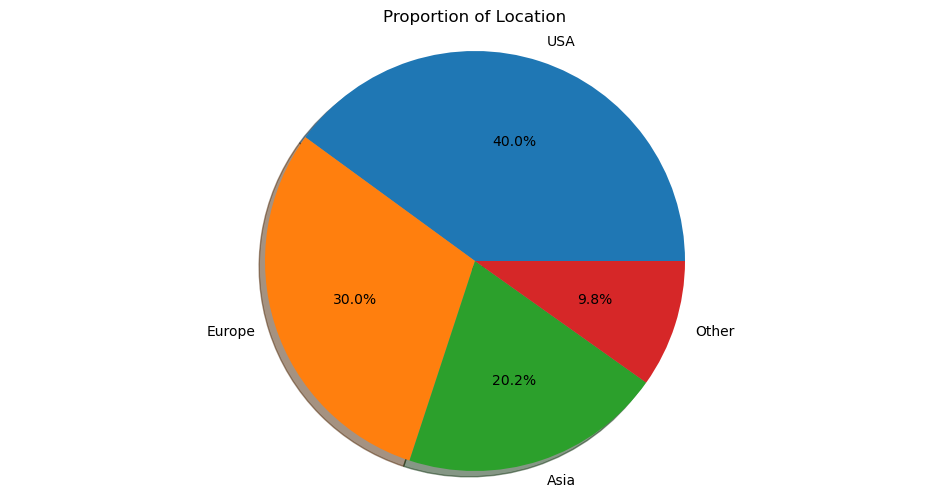

In [46]:
create_pie(raw_data,'Location')

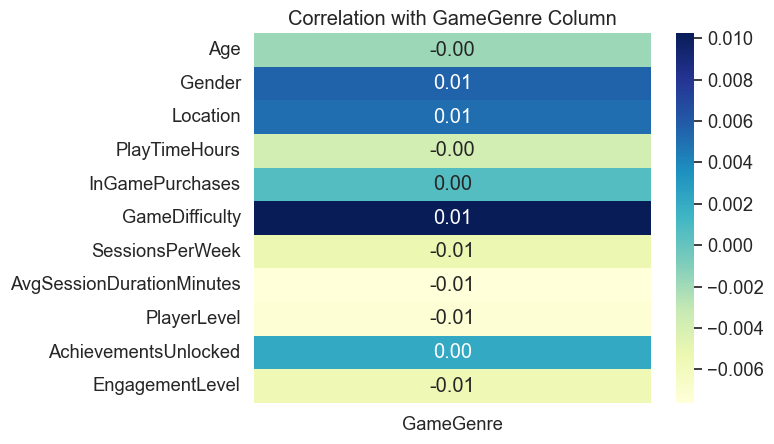

In [47]:
correlation_create(game_data, 'GameGenre')

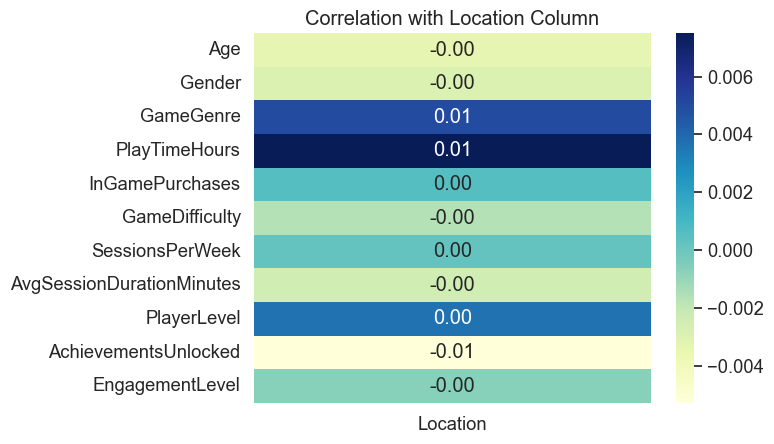

In [48]:
correlation_create(game_data, 'Location')

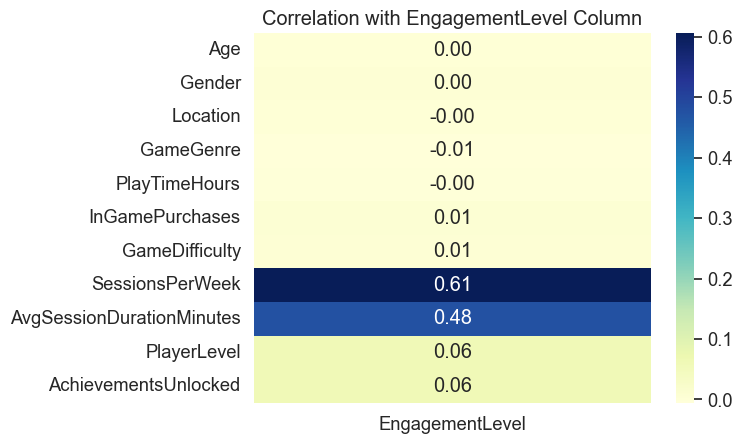

In [49]:
correlation_create(game_data, 'EngagementLevel')

#### Insights After Descriptive Analysis

We can confirm that certain game genres lead to more engagement. We preformed logistic regression on each category within the game genre.

Based on the p-value of Sports, Action, and Simulation within the first logistic summary, those genres are statistically significant in a game’s engagement level.

In the second summary, we can confirm that the USA and the Europe are also statistically significant in higher engagement levels.

However, if we view the correlation charts, we find that the most significant correlating features are SessionsPerWeek and PlayerLevel.

The pie charts help shed some light on this. While our GameGenre chart is almost-equally distributed, we can see that the second pie chart shows why the USA and Europe have higher engagement levels. They are in the majority of the distribution.

Overall, this indicates that we may not find our demographical features to correlate with the game genre, however we will continue on to the model training and testing.

<a id='ml'></a>
## 5) Splitting, Training, and Testing

Within this section, we split our dataset into a training and testing set. We then use the pipeline within our designed functions. The pipeline will preprocess the information, train the data using three defined models, then test the data on a prediction. It will then print the metrics for each model, along with the feature importances.

This is a lengthy section as we are methodically testing each target column.

####  Hypothesis: 
There is a direct correlation between demographic data and genres played, where certain demographics play certain genres. 

**Hypothesis Parameters:**
- Metrics score above 0.70 for GameGenre and priority 1 demographic data.
- Metrics are consistently above 0.70

#### Null Hypothesis: 
There is no correlation between the genre and demographic data.

**Null Hypothesis Parameters:**
- Metrics score below 0.70 for GameGenre and priority 1 demographic data.
- Metrics are not consistent 

### Model Functions

In [50]:
def model_creation(Model1, Model2, Model3, features): #transfrm=[]
    '''
    Performs model creation steps.
    
    Parameters:
    Model1 (ml model): The first model to use.
    Model2 (ml model): The second model to use.
    Model3 (ml model): The third model to use.
    features (pd.series): The column feature to analyze.
    
    Returns:
    fit_model1 (ml model): Trained model 1.
    fit_model2 (ml model): Trained model 2.
    fit_model2 (ml model): Trained model 3.
    
    '''
    
    # Scales the data
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Transforms the features columns
    preprocessor = ColumnTransformer(transformers=[
        ('nums', num_transformer, features)
    ])


    fit_model1 = model_testing(Model1, preprocessor)
    fit_model2 = model_testing(Model2, preprocessor)
    fit_model3 = model_testing(Model3, preprocessor)
    
    return fit_model1, fit_model2, fit_model3

In [51]:
def model_testing(model, preprocessor):
    '''
    Fits and predicts using the defined model.
    Prints the metrics for each individual model.
    
    Parameters: 
    model (object): The model object to train on the dataset.
    preprocessor (object): The preprocessor to use with the model.
    
    Returns:
    learner (model): Fitted model object.
    
    '''

    learner = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    learner.fit(X_train, y_train)

    y_pred = learner.predict(X_test)

    print("===========================================")
    print("Current Model: {}".format(model))
    print("Current Model's Metrics:\n")
    print(metrics.classification_report(y_test, y_pred))
    
    _importances_(model, X_train, y_train)
    
    print("===========================================")
    
    return learner

In [52]:
def _importances_(model, X_train, y_train):
    '''
    Plots out the importances by first fitting the X_train and y_train, then passing to visuals.py
    
    Parameters:
    model (object): model object to pass.
    X_train (np.array): X_trained values.
    y_train (np.array):y_trained values.
    
    Returns:
    None
    '''
    
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_

    vs.feature_plot(importances, X_train, y_train)

In [53]:
def grid_metric_report(y_test, pred, b_pred):
    '''
    Prints measurable metrics.
    
    Parameters:
    y_test (np.array): Testing data.
    pred (np.array): Predictions made by the model.
    b_pred (np.array): Best predictions made by the model.
    
    Returns:
    None
    
    '''
    
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, pred)))
    print("Recall Score on testing data: {:.4f}".format(recall_score(y_test, pred, average='macro')))
    print("Precision Score on testing data: {:.4f}".format(precision_score(y_test, pred, average='macro')))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, pred, beta = 0.5, average='macro')))
    
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, b_pred)))
    print("Recall Score on testing data: {:.4f}".format(recall_score(y_test, pred, average='macro')))
    print("Precision Score on testing data: {:.4f}".format(precision_score(y_test, pred, average='macro')))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, b_pred, beta = 0.5, average='macro')))

In [54]:
def quick_features(df, target):
    '''
    Creates a features dataset out of dataframe columns.
    
    Parameter:
    df (pd.DataFrame): The dataframe to analyze.
    target (pd.series): The column to be analyzed.
    
    Returns:
    attributes_vals (list): A list of features to analyze.
    
    '''
    
    attributes_vals = df.columns.tolist()
    
    attributes_vals.remove(target)
    
    return attributes_vals

In [55]:
def split_dataset(df, target, analyzed_feature):
    '''
    Splits the dataset into training and test sets.
    
    Parameters:
    df (pd.DataFrame): The dataframe to analyze.
    target (pd.series): The column to be analyzed.
    analyzed_feature (pd.series): List of columns to analyze.
    
    Returns:
    X_train (np.array): Trained array on X values.
    X_test (np.array): Array for testing X values.
    y_train (np.array): Trained array on y values.
    y_test (np.array): Array for testing X values.
    
    '''
    
    metric = df[target]
    
    # Assign the X_Vals
    X_Vals = df[analyzed_feature]
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_Vals,
                                                        metric, 
                                                        test_size = 0.2, 
                                                        random_state = 3)

    # Show the results of the split.
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    print('Train_Test_split Success')
    
    return X_train, X_test, y_train, y_test

### First Run — Game Genre

In [56]:
# Initialize the models.
clf_A = AdaBoostClassifier(random_state=3)
clf_B = RandomForestClassifier(random_state=3)
clf_C = DecisionTreeClassifier(random_state=3)

In [57]:
feat = quick_features(game_data, 'GameGenre')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.21      0.17      0.19      1600
           1       0.21      0.22      0.21      1645
           2       0.21      0.22      0.21      1619
           3       0.19      0.21      0.20      1576
           4       0.21      0.21      0.21      1567

    accuracy                           0.21      8007
   macro avg       0.21      0.21      0.21      8007
weighted avg       0.21      0.21      0.21      8007



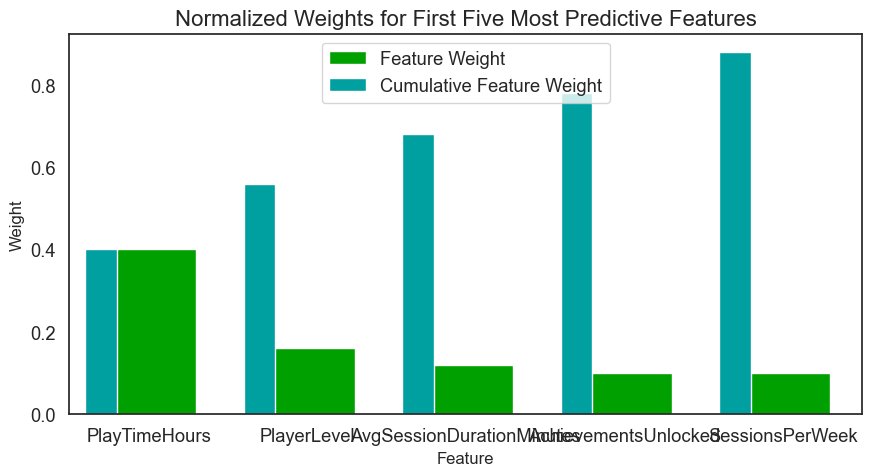

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.20      0.22      0.21      1600
           1       0.21      0.21      0.21      1645
           2       0.20      0.19      0.19      1619
           3       0.20      0.19      0.19      1576
           4       0.19      0.18      0.19      1567

    accuracy                           0.20      8007
   macro avg       0.20      0.20      0.20      8007
weighted avg       0.20      0.20      0.20      8007



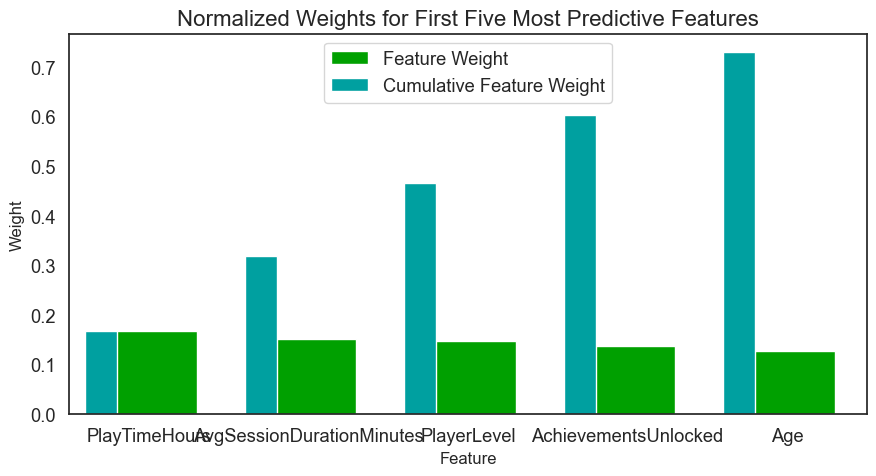

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.20      0.20      0.20      1600
           1       0.21      0.20      0.20      1645
           2       0.21      0.21      0.21      1619
           3       0.19      0.20      0.19      1576
           4       0.21      0.21      0.21      1567

    accuracy                           0.20      8007
   macro avg       0.20      0.20      0.20      8007
weighted avg       0.20      0.20      0.20      8007



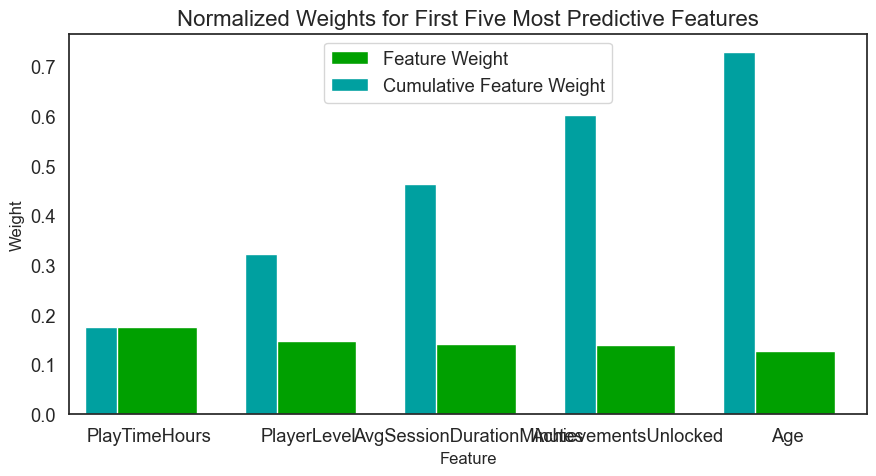

In [58]:
# Let's see how it correlates with the features
X_train, X_test, y_train, y_test = split_dataset(game_data, 'GameGenre', feat)

NUMclf_A, NUMclf_B, NUMclf_C = model_creation(clf_A, clf_B, clf_C, feat)

In this run, we used GameGenre as the target, then used our numerical features. Let's continue on to the next run.

### Second Run — Location

This second run will target a demographic feature, rather than the game genre.

In [59]:
feat = quick_features(game_data, 'Location')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.40      1.00      0.57      3226
           1       0.20      0.00      0.00      2439
           2       0.00      0.00      0.00      1558
           3       0.00      0.00      0.00       784

    accuracy                           0.40      8007
   macro avg       0.15      0.25      0.14      8007
weighted avg       0.22      0.40      0.23      8007



C:\Users\Rachel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rachel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rachel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


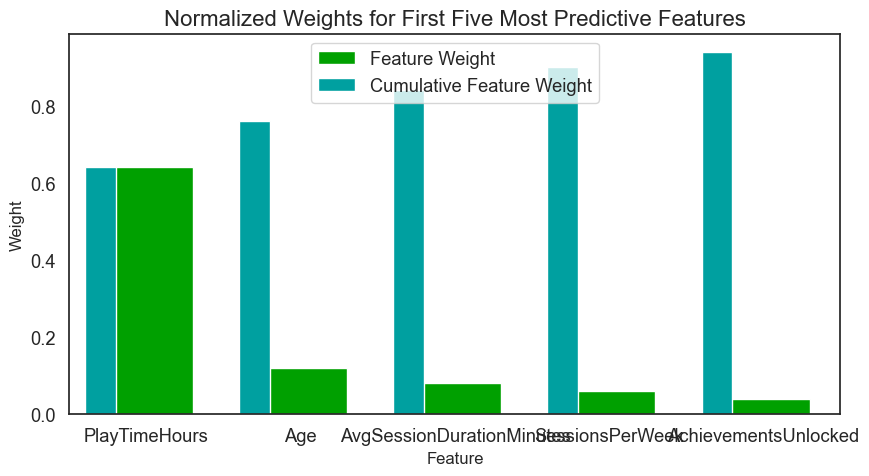

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.40      0.74      0.52      3226
           1       0.29      0.20      0.24      2439
           2       0.20      0.03      0.05      1558
           3       0.00      0.00      0.00       784

    accuracy                           0.37      8007
   macro avg       0.22      0.24      0.20      8007
weighted avg       0.29      0.37      0.29      8007



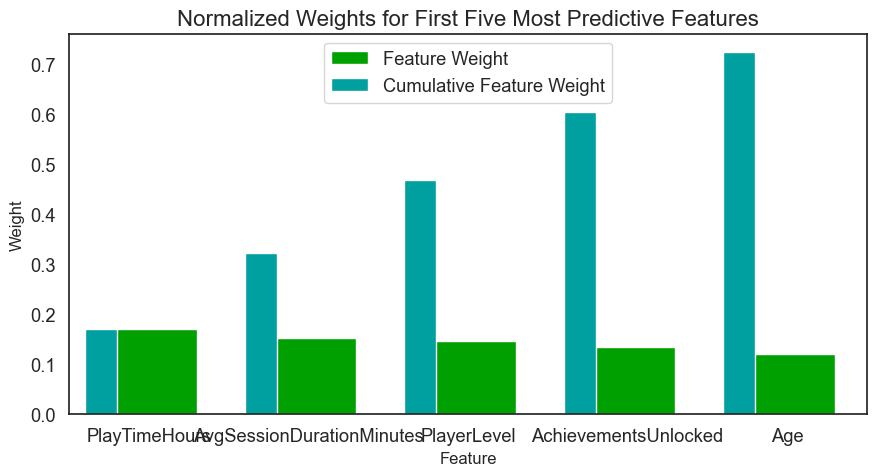

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.41      0.40      0.40      3226
           1       0.30      0.29      0.30      2439
           2       0.20      0.22      0.21      1558
           3       0.10      0.11      0.11       784

    accuracy                           0.30      8007
   macro avg       0.25      0.25      0.25      8007
weighted avg       0.31      0.30      0.30      8007



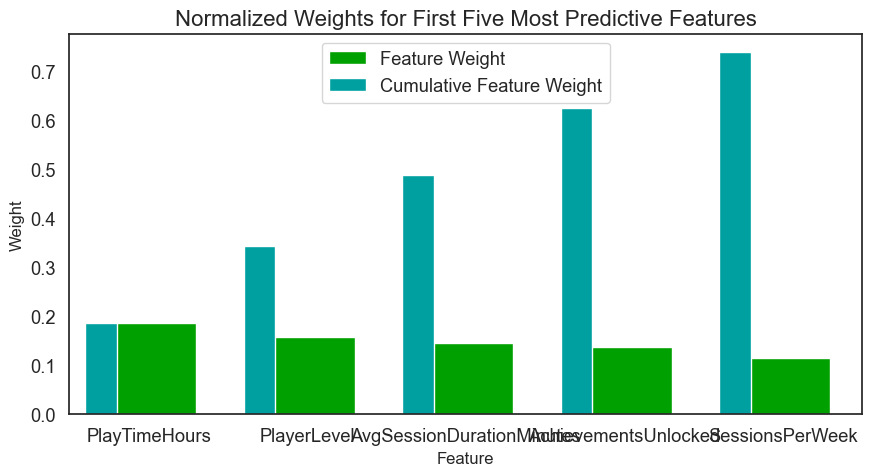

In [60]:
# Attempting the run again, but with a different target.

X_train, X_test, y_train, y_test = split_dataset(game_data, 'Location', feat)

CATclf_A, CATclf_B, CATclf_C = model_creation(clf_A, clf_B, clf_C, feat)

### Third Run — Gender

In [61]:
feat = quick_features(game_data, 'Gender')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      4768
           1       0.43      0.00      0.00      3239

    accuracy                           0.60      8007
   macro avg       0.51      0.50      0.37      8007
weighted avg       0.53      0.60      0.45      8007



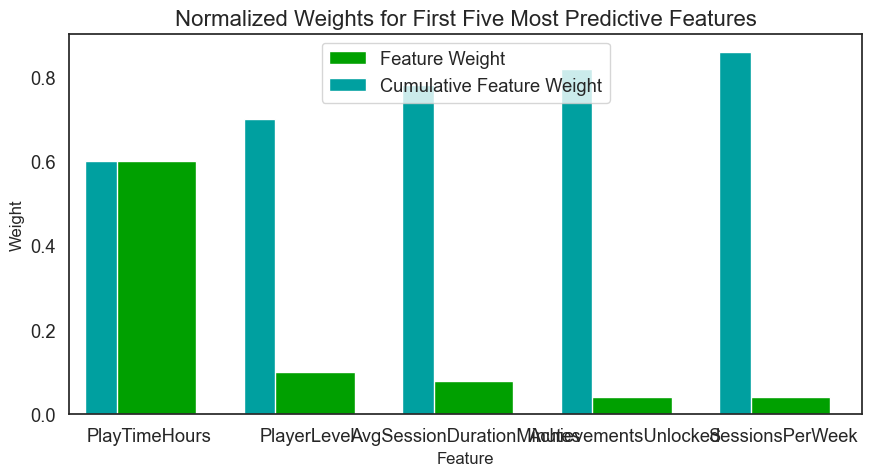

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.60      0.90      0.72      4768
           1       0.40      0.10      0.16      3239

    accuracy                           0.58      8007
   macro avg       0.50      0.50      0.44      8007
weighted avg       0.52      0.58      0.49      8007



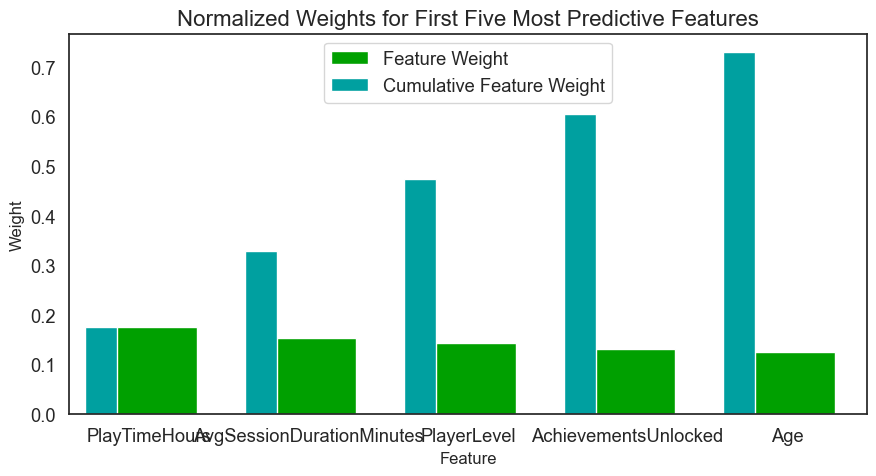

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      4768
           1       0.40      0.40      0.40      3239

    accuracy                           0.52      8007
   macro avg       0.50      0.50      0.50      8007
weighted avg       0.52      0.52      0.52      8007



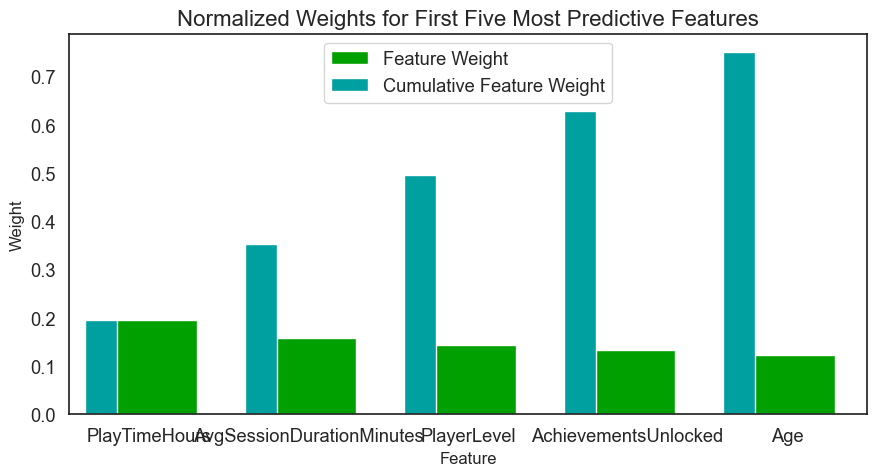

In [62]:
# Attempting the run again, but with a different target.

X_train, X_test, y_train, y_test = split_dataset(game_data, 'Gender', feat)

CATclf_A, CATclf_B, CATclf_C = model_creation(clf_A, clf_B, clf_C, feat)

### Fourth Run — Age

Let's try with our last high priority target.

In [63]:
feat = quick_features(game_data, 'Age')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

          15       0.03      0.01      0.02       221
          16       0.04      0.02      0.03       239
          17       0.04      0.04      0.04       241
          18       0.03      0.06      0.04       210
          19       0.02      0.00      0.01       228
          20       0.04      0.07      0.05       227
          21       0.04      0.04      0.04       228
          22       0.00      0.00      0.00       234
          23       0.04      0.03      0.03       219
          24       0.04      0.03      0.03       229
          25       0.04      0.05      0.04       238
          26       0.01      0.01      0.01       204
          27       0.03      0.02      0.02       238
          28       0.02      0.03      0.02       233
          29       0.03   

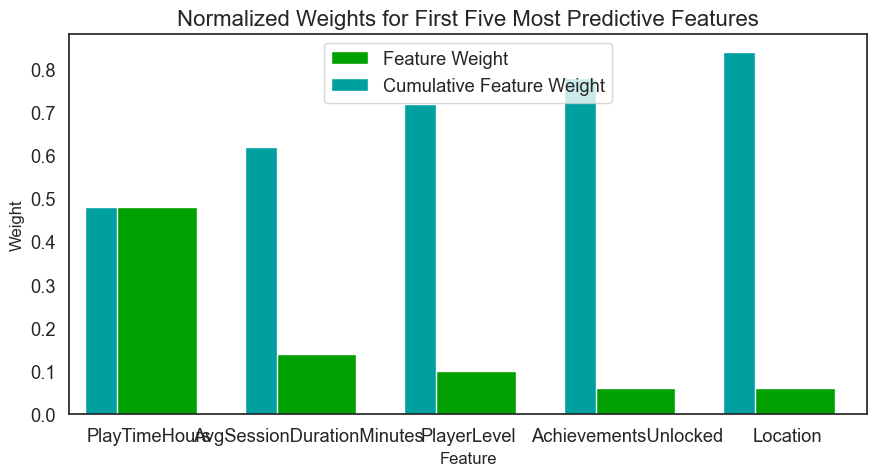

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

          15       0.02      0.03      0.03       221
          16       0.04      0.04      0.04       239
          17       0.04      0.04      0.04       241
          18       0.03      0.05      0.04       210
          19       0.02      0.02      0.02       228
          20       0.02      0.02      0.02       227
          21       0.02      0.02      0.02       228
          22       0.03      0.03      0.03       234
          23       0.03      0.03      0.03       219
          24       0.03      0.03      0.03       229
          25       0.03      0.03      0.03       238
          26       0.01      0.01      0.01       204
          27       0.03      0.03      0.03       238
          28       0.03      0.02      0.02       233
          29       0.02      0.03      0.02       224
          30       0.03      0.03      0.03       234
 

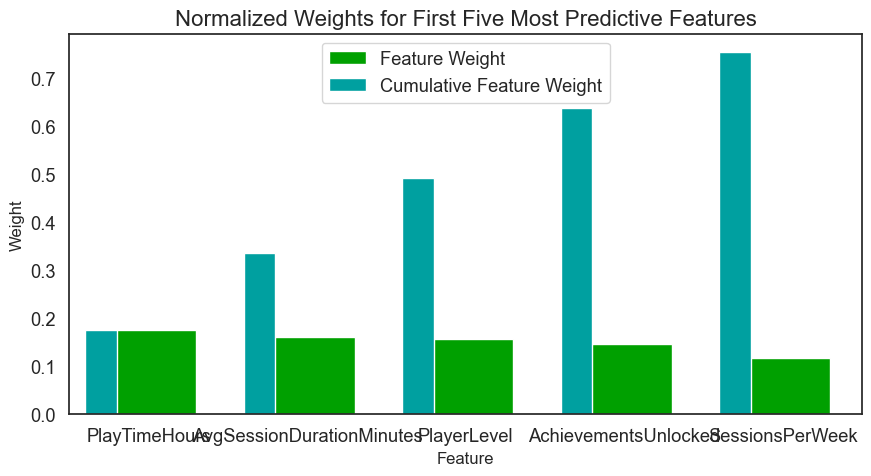

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

          15       0.01      0.01      0.01       221
          16       0.04      0.05      0.04       239
          17       0.01      0.01      0.01       241
          18       0.02      0.02      0.02       210
          19       0.03      0.03      0.03       228
          20       0.02      0.02      0.02       227
          21       0.04      0.04      0.04       228
          22       0.04      0.04      0.04       234
          23       0.02      0.02      0.02       219
          24       0.04      0.04      0.04       229
          25       0.07      0.05      0.06       238
          26       0.02      0.02      0.02       204
          27       0.02      0.02      0.02       238
          28       0.03      0.03      0.03       233
          29       0.03      0.04      0.03       224
          30       0.04      0.03      0.04       234
 

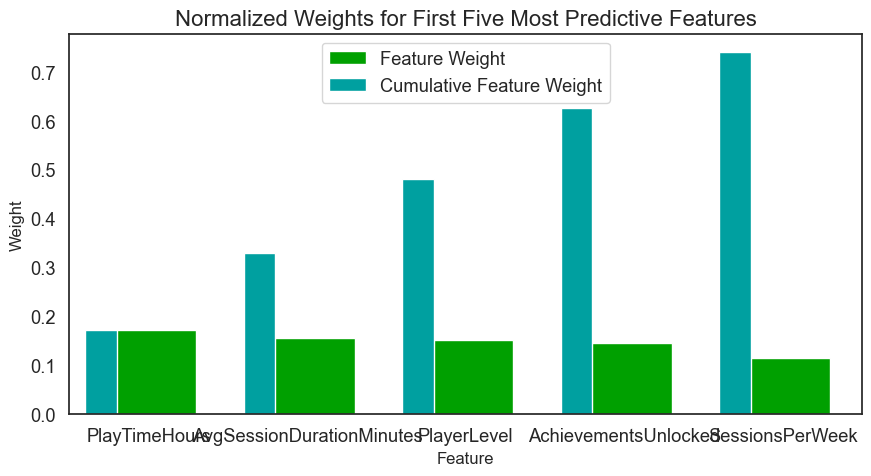

In [64]:
# Attempting the run again, but with a different target.

X_train, X_test, y_train, y_test = split_dataset(game_data, 'Age', feat)

CATclf_A, CATclf_B, CATclf_C = model_creation(clf_A, clf_B, clf_C, feat)

#### Insights on All Runs

Based on the results, this would be categorized as a failure on all models.
Each model scored wildly different metrics for each variable, and while some variables had high scores, other variables scored dangerously low. 

With these metrics and the feature importances, we can conclude that the null hypothesis has been proven. There is no correlation between the game genres and demographical features. 

With our priority list, we will use lower priority items in order to create a successful model.

In [65]:
game_feature_summary.query('priority == 2')

,attributes,type,demographic_level,priority
4,PlayTimeHours,numerical,game,2
7,SessionsPerWeek,numerical,stat,2
8,AvgSessionDurationMinutes,numerical,stat,2
11,EngagementLevel,categorical,stat,2


To note: we cannot use PlayTimeHours or AvgSessionDurationMinutes due to them being continuous variables.

### First Run With Priority Changes — Sessions Per Week

In [66]:
feat = quick_features(game_data, 'SessionsPerWeek')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.11      0.31      0.17       401
           1       0.21      0.18      0.19       396
           2       0.12      0.16      0.13       396
           3       0.07      0.04      0.05       382
           4       0.11      0.06      0.08       400
           5       0.06      0.05      0.05       418
           6       0.07      0.14      0.09       403
           7       0.09      0.22      0.13       454
           8       0.07      0.10      0.08       376
           9       0.04      0.04      0.04       371
          10       0.02      0.01      0.01       353
          11       0.08      0.00      0.01       417
          12       0.09      0.04      0.06       400
          13       0.08      0.01      0.02       410
          14       0.09   

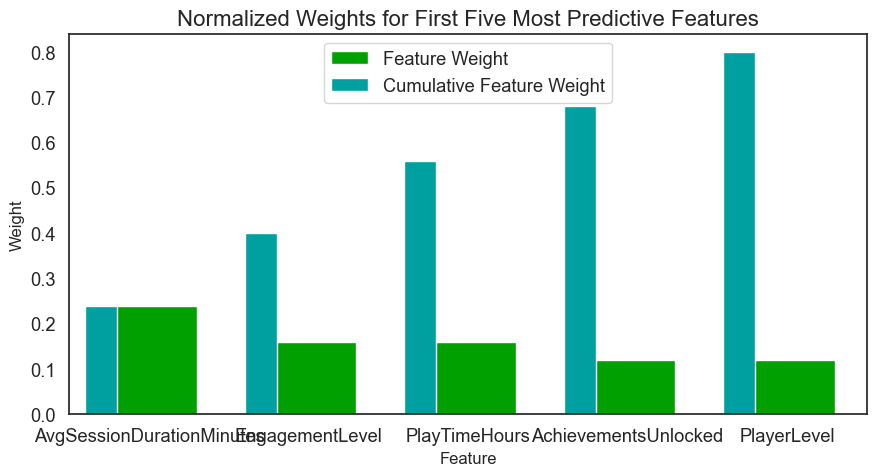

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.27      0.36      0.31       401
           1       0.18      0.22      0.20       396
           2       0.16      0.15      0.15       396
           3       0.12      0.16      0.14       382
           4       0.13      0.14      0.14       400
           5       0.09      0.08      0.09       418
           6       0.11      0.11      0.11       403
           7       0.08      0.09      0.08       454
           8       0.08      0.06      0.07       376
           9       0.07      0.07      0.07       371
          10       0.06      0.06      0.06       353
          11       0.11      0.08      0.09       417
          12       0.08      0.07      0.08       400
          13       0.10      0.08      0.09       410
          14       0.10      0.07      0.08       415
          15       0.07      0.06      0.07       377
 

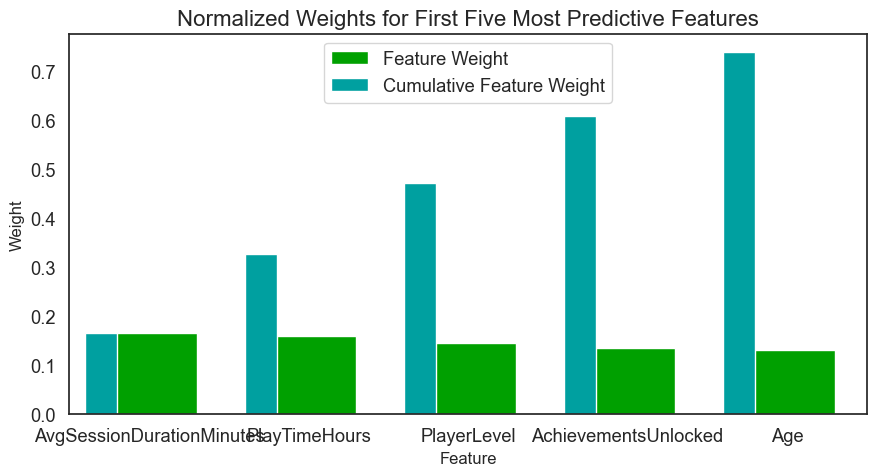

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       401
           1       0.19      0.19      0.19       396
           2       0.19      0.18      0.18       396
           3       0.12      0.14      0.13       382
           4       0.10      0.10      0.10       400
           5       0.08      0.07      0.08       418
           6       0.11      0.10      0.11       403
           7       0.10      0.09      0.09       454
           8       0.08      0.09      0.08       376
           9       0.07      0.08      0.08       371
          10       0.07      0.08      0.07       353
          11       0.08      0.07      0.07       417
          12       0.06      0.07      0.07       400
          13       0.09      0.09      0.09       410
          14       0.11      0.10      0.10       415
          15       0.09      0.10      0.10       377
 

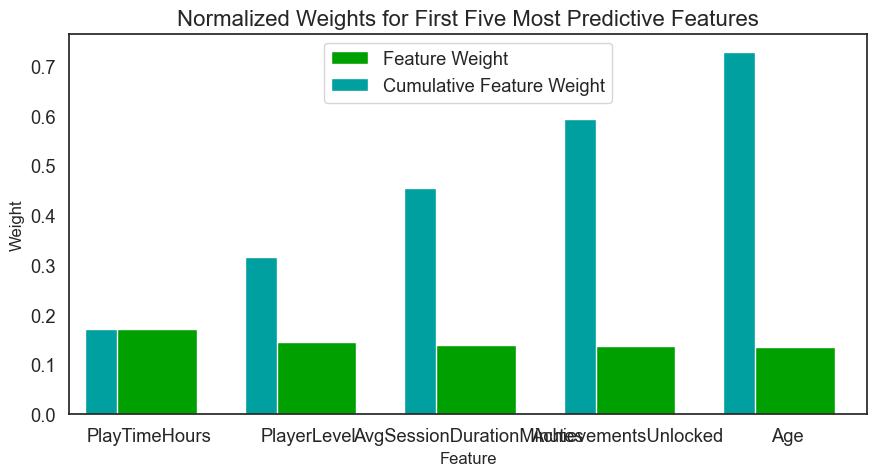

In [67]:
# Final variables defined.

X_train, X_test, y_train, y_test = split_dataset(game_data, 'SessionsPerWeek', feat)

CATclf_A, CATclf_B, CATclf_C = model_creation(clf_A, clf_B, clf_C, feat)

### Second Run With Priority Changes — Engagement Level

In [68]:
feat = quick_features(game_data, 'EngagementLevel')

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success
Current Model: AdaBoostClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      2092
           1       0.76      0.91      0.83      3859
           2       0.89      0.73      0.80      2056

    accuracy                           0.80      8007
   macro avg       0.83      0.77      0.79      8007
weighted avg       0.81      0.80      0.80      8007



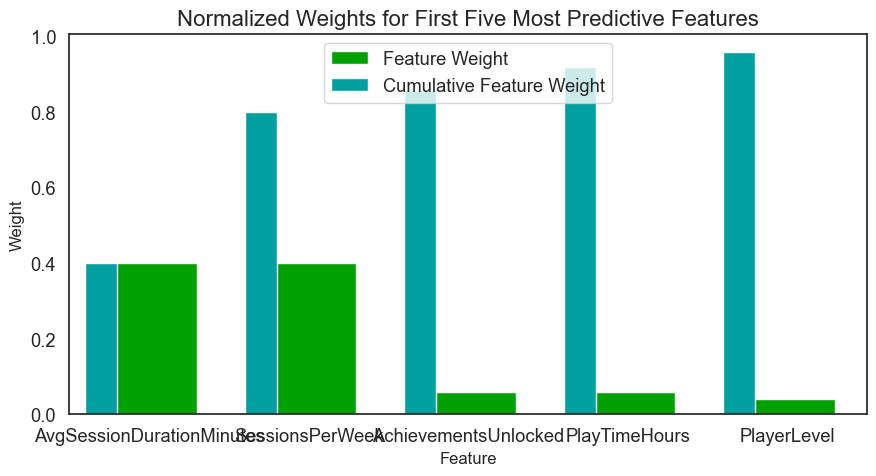

Current Model: RandomForestClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2092
           1       0.90      0.95      0.93      3859
           2       0.92      0.87      0.89      2056

    accuracy                           0.91      8007
   macro avg       0.91      0.90      0.90      8007
weighted avg       0.91      0.91      0.91      8007



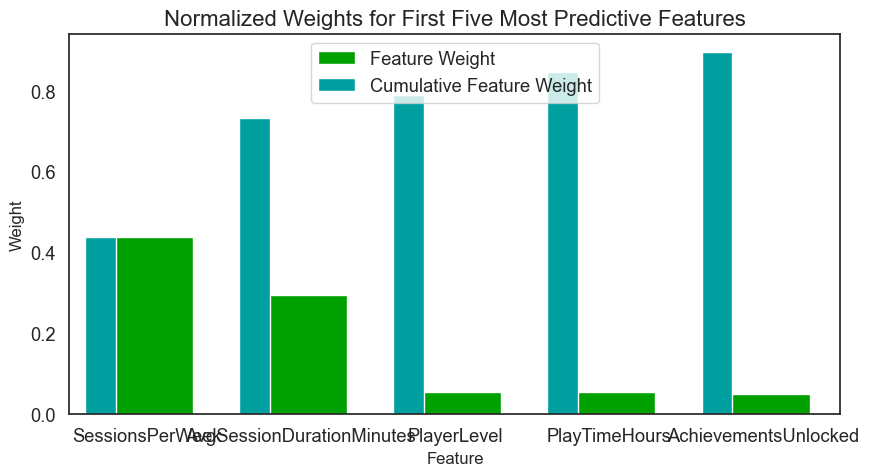

Current Model: DecisionTreeClassifier(random_state=3)
Current Model's Metrics:

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2092
           1       0.88      0.86      0.87      3859
           2       0.82      0.82      0.82      2056

    accuracy                           0.84      8007
   macro avg       0.83      0.83      0.83      8007
weighted avg       0.84      0.84      0.84      8007



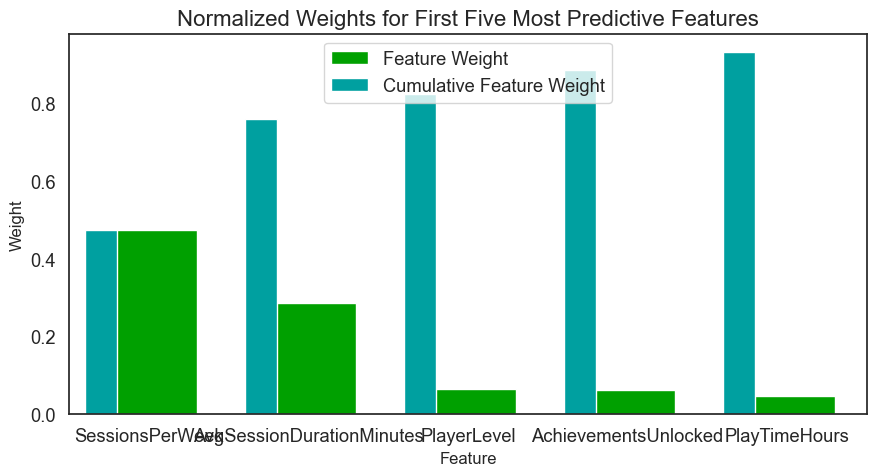

In [69]:
# Final variables defined.

X_train, X_test, y_train, y_test = split_dataset(game_data, 'EngagementLevel', feat)

CATclf_A, CATclf_B, CATclf_C = model_creation(clf_A, clf_B, clf_C, feat)

**Insights**

Finally, we meet success with the EngagementLevel. The most successful model with this target is RandomForestClassifier, which scored the highest out of all models.

We will now move on to refining, now that our parameter tests are complete.

### Refining Model

In [70]:
#### This code may take a while to run due to the model being used ####
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state=3)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'n_estimators': [185, 285, 385, 485]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
grid_metric_report(y_test, predictions, best_predictions)

Unoptimized model
------
Accuracy score on testing data: 0.9095
Recall Score on testing data: 0.8979
Precision Score on testing data: 0.9120
F-score on testing data: 0.9088

Optimized Model
------
Final accuracy score on the testing data: 0.9096
Recall Score on testing data: 0.8979
Precision Score on testing data: 0.9120
Final F-score on the testing data: 0.9091


#### Results with EngagementLevel:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.9095      |      0.9096     |
| Recall Score   |       0.8979      |      0.8979     |
| Precision Score|       0.9120      |      0.9120     |
| F-score        |       0.9088      |      0.9091     |

<a id='testing'></a>
## 6) Conducting Tests

Now that we have our model, we can continue on to our tests.

### Testing Functions

These functions are defined within testing.py. Running testing.py will run every individual test.

In [71]:
feat = quick_features(game_data, 'EngagementLevel')

X_train, X_test, y_train, y_test = split_dataset(game_data, 'EngagementLevel', feat)

selected_model = RandomForestClassifier(random_state=3)
model1 = AdaBoostClassifier(random_state=3)
model2 = DecisionTreeClassifier(random_state=3)

Training set has 32027 samples.
Testing set has 8007 samples.
Train_Test_split Success


In [72]:
def test_success_criteria(model):
    """
    Tests to confirm that the scores meet the success criteria.
    """
    
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    assert accuracy_score(y_test, pred) >= 0.7
    assert recall_score(y_test, pred, average='macro') >= 0.7
    assert precision_score(y_test, pred, average='macro') >= 0.7
    assert fbeta_score(y_test, pred, beta = 0.5, average='macro') >= 0.7

In [73]:
def test_best_model(model1, model2, selected_model):
    '''
    Tests the best model out of the three.
    
    '''
    model1 = model1.fit(X_train, y_train)
    pred = model1.predict(X_test)
    score1 = fbeta_score(y_test, pred, beta = 0.5, average='macro')
    
    model2 = model2.fit(X_train, y_train)
    pred = model2.predict(X_test)
    score2 = fbeta_score(y_test, pred, beta = 0.5, average='macro')
    
    selected_model = selected_model.fit(X_train, y_train)
    pred = selected_model.predict(X_test)
    score3 = fbeta_score(y_test, pred, beta = 0.5, average='macro')
    
    if score1 > score2:
        if score1 > score3:
            best_model = model1
        else:
            best_model = selected_model
    elif score2 > score3:
        best_model = model2
    else:
        best_model = selected_model
    
    assert best_model == selected_model

In [74]:
def test_encoded():
    '''
    Tests the encoded features and confirms that they are accurate
    '''
    encoded = list(game_data.columns)
    assert len(encoded) == 12

In [75]:
test_encoded()

In [76]:
test_success_criteria(selected_model)

In [77]:
test_best_model(model1, model2, selected_model)

All tests passed without throwing any errors. We can proceed with analyzing and refining our metric results.

<a id='analyze'></a>
## 7) Analyzing Metric Results

Here, we view the most important features that influence EngagementLevel.

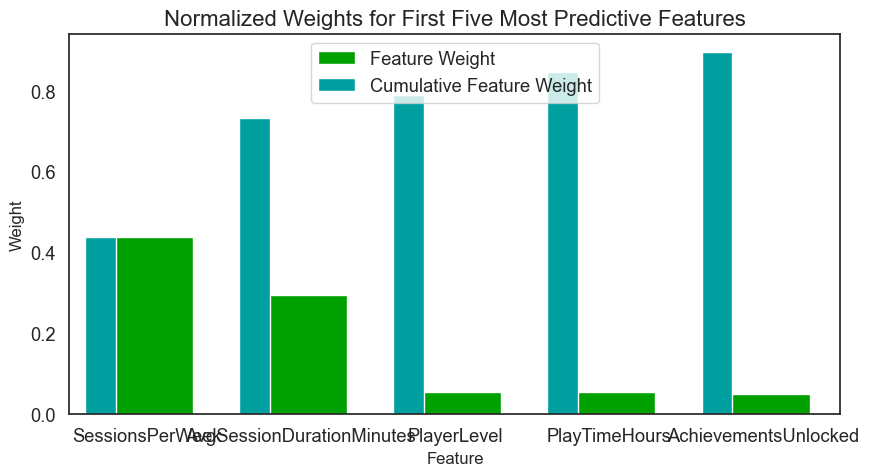

In [78]:
model = RandomForestClassifier(random_state=3) # max_depth=7, n_estimators=485
model = model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [79]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average='macro')))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5, average='macro')))

Final Model trained on full data
------
Accuracy on testing data: 0.9096
F-score on testing data: 0.9091

Final Model trained on reduced data
------
Accuracy on testing data: 0.9182
F-score on testing data: 0.9165


#### Full vs. Reduced with EngagementLevel:

|     Metric     | Full Data         | Reduced Data    |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.9096      |      0.9182     |
| F-score        |       0.9091      |      0.9165     |

<a id='datasets'></a>
## 8) Creating datasets with Results

In [80]:
def generate_features_df(model, feat):
    '''
    Creates a feature importances dataframe.
    
    Parameters:
    model (model): Trained model to generate features from.
    feat(pd.series): Column to predict.
    
    Returns:
    df (pd.DataFrame): DataFrame object with feature importances.
    '''
    
    x = list(zip(model.feature_importances_, feat))
    df = pd.DataFrame(x, columns=["Importance", "Attribute"])
    
    return df

In [81]:
# Create a dataframe of metrics.

def generate_metric_df(df, target):
    '''
    Creates a dataframe of the metrics by re-running the ml model, but without our pipeline.
    
    Parameters:
    df (pd.DataFrame): Dataframe to use with prediction
    target (pd.series): Column name to predict.
    
    Returns:
    report_df (pd.DataFrame): DataFrame of metrics reported.
    important_features (pd.DataFrame): DataFrame of important features.
    '''
    metric = df[target]

    feat = quick_features(df, target)

    X_Vals = df[feat]

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_Vals,
                                                        metric, 
                                                        test_size = 0.2, 
                                                        random_state = 3)
    num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])

    preprocessor = ColumnTransformer(transformers=[
        ('nums', num_transformer, feat)
    ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=3))
    ])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Quickly create the feature importances df
    model = RandomForestClassifier(random_state=3)
    model = model.fit(X_train, y_train)
    important_features = generate_features_df(model, feat)
    
    return report_df, important_features

In [82]:
feat = quick_features(game_data, 'EngagementLevel')

In [83]:
GameGenre_df, GG_importances = generate_metric_df(game_data, 'GameGenre')

In [84]:
EL_df, EL_importances = generate_metric_df(game_data, 'EngagementLevel')

<a id='extracting'></a>
## 9) Extracting the Datasets

Now that our analysis is complete, we can begin exporting our results and our datasets.

In [85]:
# Exporting Clean Dataset
game_data.to_csv('cleaned_game_data.csv', index=False)

In [86]:
# Export the GameGenre Metrics and feature importances
GameGenre_df.to_csv('GG_metrics.csv', index=False)
GG_importances.to_csv('GG_importances.csv', index=False)

In [87]:
# Export the EngagementLevel Metrics and feature importances
EL_df.to_csv('EL_df.csv', index=False)
EL_importances.to_csv('EL_importances.csv', index=False)

<a id='conclusion'></a>
## 10) Conclusion

Our anticipated goal was to thoroughly prove that demographic features could be used to predict the engagement level of certain genres. However, as we conducted our analysis, it quickly became clear that the distribution of the data did not allow for predicted game genres based on those demographical features.

We were able to pivot to our lower priority features. The reason they are lower priority is that they do not refer to a person’s personal information, such as age, location, or gender. After pivoting, we found that engagement level was the main variable that could be predicted with accuracy scores above 0.70 regularly.

Our conclusion is that there is no correlation between game genres and demographical features. Our null hypothesis is proven. 